In [20]:
from keras.applications import VGG16
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1648s 28us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_

In [17]:
# 提取特征
train_dir = r"C:\Users\WW\Desktop\Python\keras\dogs-vs-cats\train"
validation_dir = r"C:\Users\WW\Desktop\Python\keras\dogs-vs-cats\validation"
test_dir = r"C:\Users\WW\Desktop\Python\keras\dogs-vs-cats\test"

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20 

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count,))
    
    generator = datagen.flow_from_directory(directory, 
                                            target_size = (150, 150), 
                                            batch_size = batch_size, 
                                            class_mode = "binary")
    # 这里用i来控制生成器的迭代次数
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# 因为接下来要使用Flatten层，所以对特征进行reshape
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
# 构建自己的分类层
model = Sequential()

model.add(Dense(units = 256, activation = "relu", input_dim = (4 * 4 * 512)))
model.add(Dropout(0.25))

model.add(Dense(units = 1, activation = "sigmoid"))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 编译模型
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

# 运行模型
history = model.fit(train_features, 
                    train_labels, 
                    batch_size = 20, 
                    epochs = 30, 
                    validation_data = (validation_features, validation_labels), 
                    verbose = 1)

# 测试模型
score = model.evaluate(test_features, test_labels, verbose = 1)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 582us/step - loss: 0.3989 - acc: 0.9250 - val_loss: 0.4473 - val_acc: 0.8730
Epoch 2/30
2000/2000 [==============================] - 1s 404us/step - loss: 0.1964 - acc: 0.9430 - val_loss: 0.5454 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 398us/step - loss: 0.1547 - acc: 0.9510 - val_loss: 0.4667 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 411us/step - loss: 0.1163 - acc: 0.9630 - val_loss: 0.4796 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 1s 400us/step - loss: 0.1007 - acc: 0.9705 - val_loss: 0.6184 - val_acc: 0.8620
Epoch 6/30
2000/2000 [==============================] - 1s 393us/step - loss: 0.0706 - acc: 0.9785 - val_loss: 0.7103 - val_acc: 0.8720
Epoch 7/30
2000/2000 [==============================] - 1s 400us/step - loss: 0.0594 - acc: 0.9815 - val_loss: 0.6360 - val_acc: 0.8770


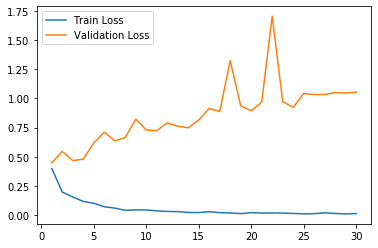

In [24]:
# 绘制结果
plt.figure()
epochs = [i for i in range(1, len(history.history["loss"]) + 1)]
plt.plot(epochs, history.history["loss"], label = "Train Loss")
plt.plot(epochs, history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

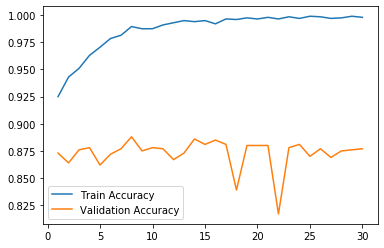

In [25]:
plt.figure()
plt.plot(epochs, history.history["acc"], label = "Train Accuracy")
plt.plot(epochs, history.history["val_acc"], label = "Validation Accuracy")
plt.legend()
plt.show()